In [1]:
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn

# !pip install tqdm
# !pip install rougue-score
# !pip install seaborn
# !pip install matplotlib
# !pip install evaluate
# !pip install nltk

In [2]:
import lmstudio as lms
import os
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from tqdm import tqdm
import time  # optional, for example timing

import evaluate

import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

d:\06_class_notes\2025_spring\deep_learning\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# setup directories
EVAL_DIR = './eval'
os.makedirs(EVAL_DIR, exist_ok=True)

OUTPUT_DIR = './output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# retrieve test set manually labeled for each task
df = pd.read_csv(os.path.join(EVAL_DIR, "test_data.csv"), index_col='Unnamed: 0', encoding='cp1252')

In [5]:
df.head()

,content,sentiment,key_phrase,summary
148,HTML and CSS if very nicely covered but later ...,-1,everything has updated so much that it became ...,This reviewer is satisfied with HTML and CSS t...
49,"Initially, I rated this course 5 stars and EVE...",-1,huge disappointment at the end,The course started off strong but fell off due...
138,Best course ever for web development. No one c...,1,Best course ever for web development.,The reviewer praises the course for its compre...
91,The course is good ! BUT I think when teaching...,0,The course is good !,"The course is overall good, but the reviewer s..."
119,"just a average course, she just ask you to rea...",-1,room for lots of improvement,"The reviewer considers the course average, cit..."


In [6]:
df.shape

(50, 4)

## 1. Prompt Engineering

In [7]:
def sentiment_classification(reviews, model, prompt_ver=1):
    res = []
    for review in reviews:
        # define response format
        response_schema = {
            "type": "object",
            "properties": {
                "sentiment": { "type": "integer" },
            },
            "required": ["sentiment"],
        }
        # construct prompt
        if prompt_ver==1:
            prompt = f""" 
            Classify the sentiment of the following customer review as 1 if it is overall positive, 0 if neutral, or -1 if negative.
            Review: {review}
            """
        elif prompt_ver==2:
            prompt = f""" 
            What is the sentiment of the following customer review?
            Use the label 1 for positive, 0 for neutral, and -1 for negative.
            Review: {review}
            """
        elif prompt_ver==3:
            prompt = f"""
            You are a sentiment analysis assistant. 
            Read the following customer review and classify its overall sentiment as 1 for positive , 0 for neutral, or -1 for negative, based on the customer's tone and opinion. 
            Review: {review}
            """

        response = model.respond(prompt, response_format=response_schema)

        res.append({
            'review': review,
            'sentiment': response.parsed['sentiment'],
        })

    return res

In [8]:
def phrase_extraction(reviews, model, prompt_ver=1):
    res = []
    for review in reviews:
        # define response format
        response_schema = {
            "type": "object",
            "properties": {
                "key_phrase": { "type": "string" },
            },
            "required": ["key_phrase"],
        }
        # construct prompt
        if prompt_ver==1:
            prompt = f""" 
            Extract the most significant phrase of praise or complaint from the following review. 
            Review: {review}
            """
        elif prompt_ver==2:
            prompt = f"""
            What is the most significant phrase of praise or complaint from the following review?
            Extract a key phrase or sentence.
            Review: {review}
            """
        elif prompt_ver==3:
            prompt = f"""
            You are an assistant analyzing customer feedback on online courses. 
            Your task is to extract a key phrase of praises or complaints mentioned in the review. 
            Review: {review}
            """

        response = model.respond(prompt, response_format=response_schema)

        res.append({
            'review': review,
            'key_phrase': response.parsed['key_phrase'],
        })

    return res

In [9]:
def review_summarization(reviews, model, prompt_ver=1):
    res = []
    for review in reviews:
        # define response format
        response_schema = {
            "type": "object",
            "properties": {
                "summary": { "type": "string" },
            },
            "required": ["summary"],
        }
        # construct prompt
        if prompt_ver==1:
            prompt = f""" 
            Provide a 1-2 sentence summary of the given review.
            Review: {review}
            """
        elif prompt_ver==2:
            prompt = f"""
            What is the overall experience and opinion of the customer based on the following review? Summarize it in 1-2 sentences.
            Review: {review}
            """
        elif prompt_ver==3:
            prompt = f"""
            You are a helpful assistant summarizing customer feedback for an online course. 
            Write a short (1-2 sentence) summary that captures the core experience and opinion of the customer.
            Review: {review}
            """

        response = model.respond(prompt, response_format=response_schema)

        res.append({
            'review': review,
            'summary': response.parsed['summary'],
        })

    return res

## 2. Obtaining prediction / responses

### 2.1. llama-3.2-3b-instruct

In [10]:
# load model
MODEL_NAME = "llama-3.2-3b-instruct"
model = lms.llm(MODEL_NAME)

#### 1.1.1. Task 1: Sentiment classification

In [11]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    sentiments = sentiment_classification(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task1_df = pd.DataFrame(sentiments)
    task1_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_1_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:55<01:50, 55.11s/it]

Version 1 done in 55.10 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [01:47<00:53, 53.30s/it]

Version 2 done in 52.00 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [02:40<00:00, 53.45s/it]

Version 3 done in 53.17 seconds


#### 1.1.2. Task 2: Key complaint or praise extraction

In [12]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    phrases = phrase_extraction(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task2_df = pd.DataFrame(phrases)
    task2_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_2_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [01:15<02:30, 75.34s/it]

Version 1 done in 75.31 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [02:32<01:16, 76.11s/it]

Version 2 done in 76.62 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [03:40<00:00, 73.46s/it]

Version 3 done in 68.35 seconds


#### 1.1.3. Task 3: Review summarization

In [13]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    summaries = review_summarization(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task3_df = pd.DataFrame(summaries)
    task3_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_3_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [02:53<05:47, 173.70s/it]

Version 1 done in 173.65 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [05:51<02:56, 176.03s/it]

Version 2 done in 177.63 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [09:06<00:00, 182.01s/it]

Version 3 done in 194.66 seconds


In [14]:
# unload the model
model.unload()

### 2.2. gemma-3-4b-it

In [15]:
# load model
MODEL_NAME = "gemma-3-4b-it"
model = lms.llm(MODEL_NAME)

#### 2.2.1. Task 1: Sentiment classification

In [16]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    sentiments = sentiment_classification(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task1_df = pd.DataFrame(sentiments)
    task1_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_1_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:38<01:17, 38.56s/it]

Version 1 done in 38.55 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [01:16<00:38, 38.33s/it]

Version 2 done in 38.17 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [01:52<00:00, 37.65s/it]

Version 3 done in 36.21 seconds


#### 2.2.2. Task 2: Key complaint or praise extraction

In [17]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    phrases = phrase_extraction(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task2_df = pd.DataFrame(phrases)
    task2_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_2_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:45<01:31, 45.64s/it]

Version 1 done in 45.64 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [01:49<00:56, 56.29s/it]

Version 2 done in 63.74 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [02:41<00:00, 53.76s/it]

Version 3 done in 51.89 seconds


#### 2.2.3. Task 3: Review summarization

In [18]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    summaries = review_summarization(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task3_df = pd.DataFrame(summaries)
    task3_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_3_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [01:57<03:54, 117.41s/it]

Version 1 done in 117.41 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [04:07<02:04, 124.67s/it]

Version 2 done in 129.73 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [05:57<00:00, 119.31s/it]

Version 3 done in 110.78 seconds


In [19]:
# unload model
model.unload()

### 2.3. falcon3-3b-instruct

In [20]:
# load model
MODEL_NAME = "falcon3-3b-instruct"
model = lms.llm(MODEL_NAME)

#### 2.2.1. Task 1: Sentiment classification

In [21]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    sentiments = sentiment_classification(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task1_df = pd.DataFrame(sentiments)
    task1_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_1_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:14<00:29, 14.90s/it]

Version 1 done in 14.90 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [00:29<00:14, 14.72s/it]

Version 2 done in 14.59 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [00:45<00:00, 15.03s/it]

Version 3 done in 15.58 seconds


#### 2.2.2. Task 2: Key complaint or praise extraction

In [22]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    phrases = phrase_extraction(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task2_df = pd.DataFrame(phrases)
    task2_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_2_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:24<00:49, 24.71s/it]

Version 1 done in 24.71 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [00:50<00:25, 25.07s/it]

Version 2 done in 25.32 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [01:11<00:00, 23.78s/it]

Version 3 done in 21.29 seconds


#### 2.2.3. Task 3: Review summarization

In [23]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    summaries = review_summarization(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task3_df = pd.DataFrame(summaries)
    task3_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_3_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:41<01:22, 41.12s/it]

Version 1 done in 41.12 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [01:19<00:39, 39.70s/it]

Version 2 done in 38.71 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [02:02<00:00, 40.81s/it]

Version 3 done in 42.61 seconds


In [24]:
# unload model
model.unload()

## 3. Evaluation

In [25]:
llama_model = "llama-3.2-3b-instruct"
gemma_model = "gemma-3-4b-it"
falcon_model = "falcon3-3b-instruct"

### 3.1. Task 1: Sentiment classification

#### F1 score

In [26]:
def get_f1_score(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_1_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_1_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_1_v{prompt_ver}.csv"))
    
    # calculate f1 score & accuracy score
    llama_f1 = f1_score(df['sentiment'], llama_['sentiment'], average='micro')
    gemma_f1 = f1_score(df['sentiment'], gemma_['sentiment'], average='micro')
    falcon_f1 = f1_score(df['sentiment'], falcon_['sentiment'], average='micro')

    # print result
    print(f'Prompt version {prompt_ver}:')
    print(f'{llama_model}: {llama_f1:.2f}')
    print(f'{gemma_model}: {gemma_f1:.2f}')
    print(f'{falcon_model}: {falcon_f1:.2f}')
    print()

In [27]:
for i in range(1, 4):
    get_f1_score(i)

Prompt version 1:
llama-3.2-3b-instruct: 0.86
gemma-3-4b-it: 0.84
falcon3-3b-instruct: 0.82

Prompt version 2:
llama-3.2-3b-instruct: 0.78
gemma-3-4b-it: 0.88
falcon3-3b-instruct: 0.84

Prompt version 3:
llama-3.2-3b-instruct: 0.82
gemma-3-4b-it: 0.84
falcon3-3b-instruct: 0.88



#### Confusion matrix

In [28]:
def get_confusion_matrix(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_1_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_1_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_1_v{prompt_ver}.csv"))

    # calculate confusion matrix
    llama_cm = confusion_matrix(df['sentiment'], llama_['sentiment'], labels=[-1, 0, 1])
    gemma_cm = confusion_matrix(df['sentiment'], gemma_['sentiment'], labels=[-1, 0, 1])
    falcon_cm = confusion_matrix(df['sentiment'], falcon_['sentiment'], labels=[-1, 0, 1])

    # Plot result
    # Plot side by side
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    sns.heatmap(llama_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=[-1,0,1], yticklabels=[-1,0,1],)
    axes[0].set_title(f'Llama - prompt version {prompt_ver}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(gemma_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=[-1,0,1], yticklabels=[-1,0,1],)
    axes[1].set_title(f'Gemma - prompt version {prompt_ver}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    sns.heatmap(falcon_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], xticklabels=[-1,0,1], yticklabels=[-1,0,1],)
    axes[2].set_title(f'Falcon - prompt version {prompt_ver}')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')

    plt.tight_layout()
    plt.show()

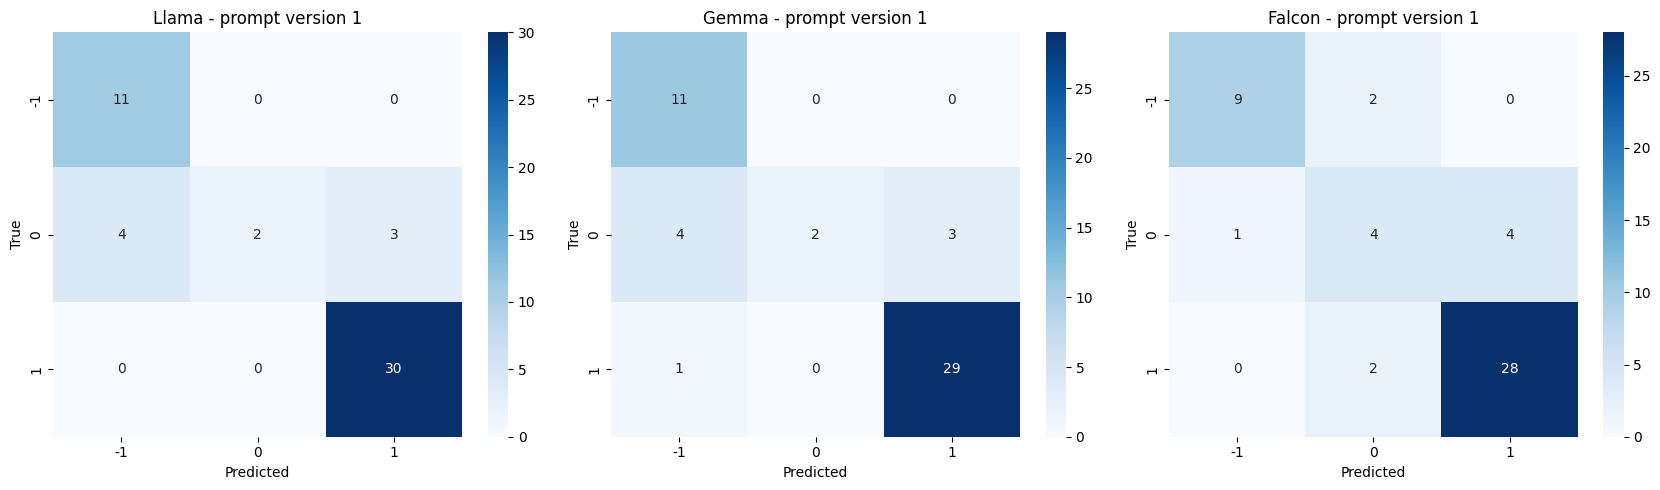

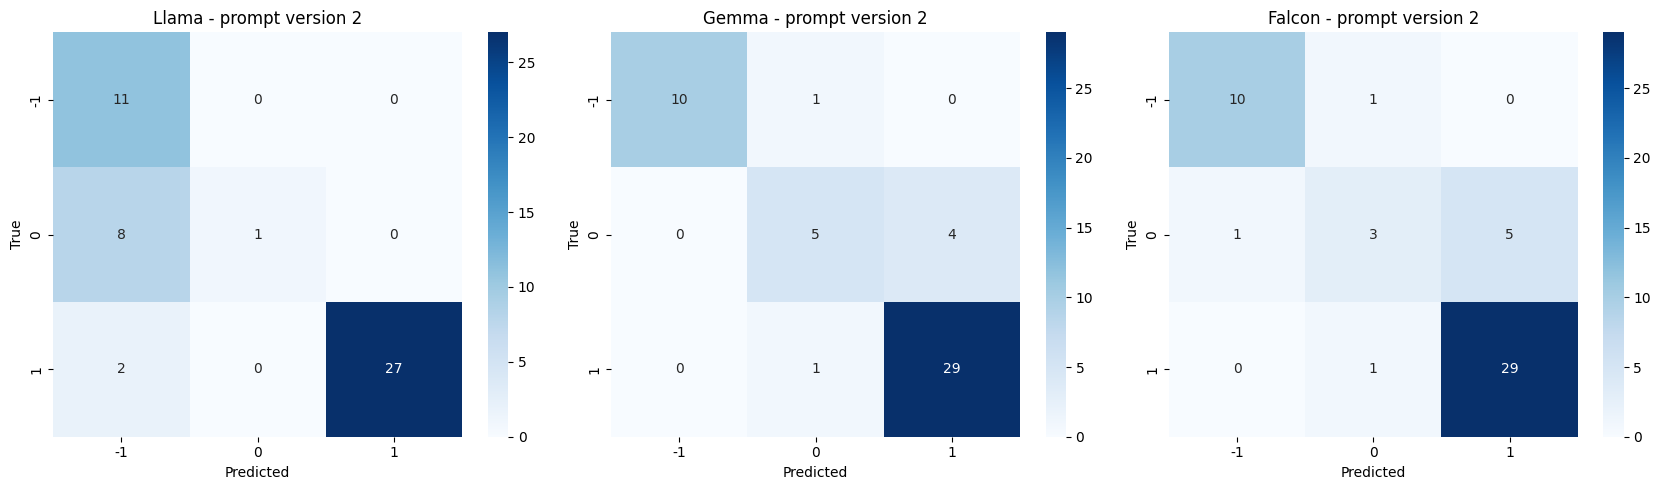

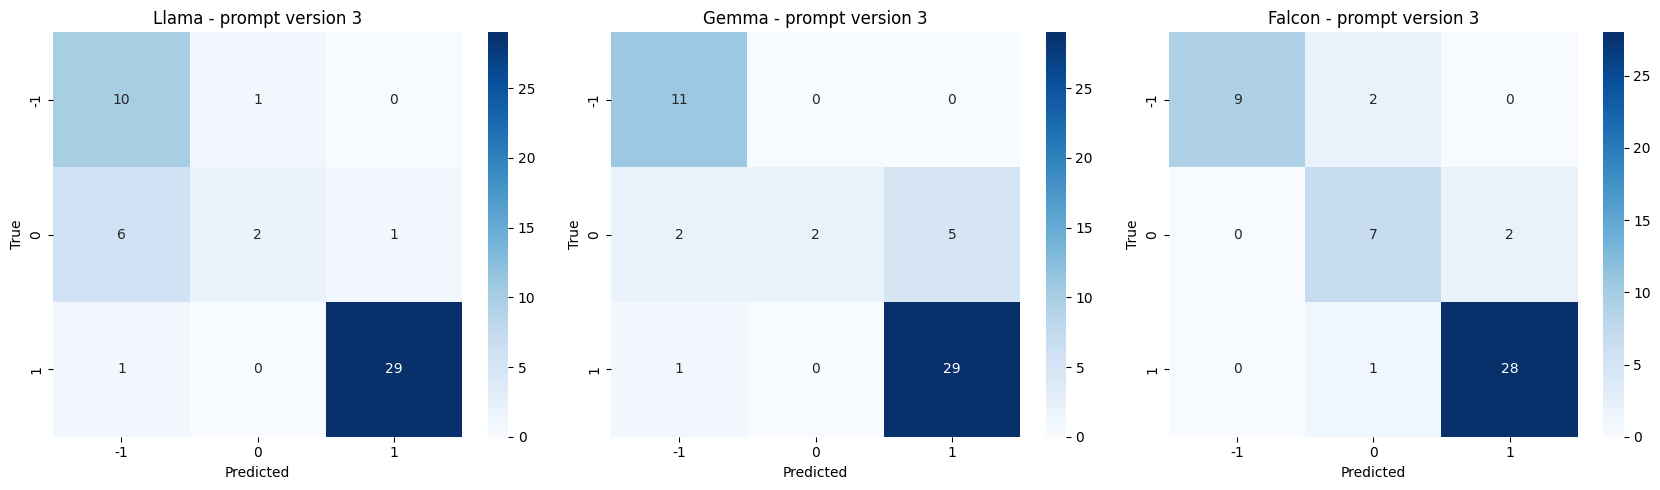

In [29]:
for i in range(1, 4):
    get_confusion_matrix(i)

### 3.2. Task 2: Phrase extraction

#### Token-level Precision / Recall / F1

In [30]:
# from sklearn.metrics import precision_score, recall_score, f1_score

def token_level_scores(pred, gold):
    pred_tokens = pred.split()
    gold_tokens = gold.split()
    pred_set = set(pred_tokens)
    gold_set = set(gold_tokens)
    
    true_positives = len(pred_set & gold_set)
    precision = true_positives / len(pred_set) if pred_set else 0
    recall = true_positives / len(gold_set) if gold_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    
    return precision, recall, f1


def get_token_level_scores(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_2_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_2_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_2_v{prompt_ver}.csv"))

    # calculate average token level precision, recall, f1
    llama_precision = []
    llama_recall = []
    llama_f1 = []

    gemma_precision = []
    gemma_recall = []
    gemma_f1 = []

    falcon_precision = []
    falcon_recall = []
    falcon_f1 = []


    for gold_, llama_pred_, gemma_pred_, falcon_pred_ in zip(df['key_phrase'], llama_['key_phrase'], gemma_['key_phrase'], falcon_['key_phrase']):
        llama_scores = token_level_scores(llama_pred_, gold_)
        gemma_scores = token_level_scores(gemma_pred_, gold_)
        falcon_scores = token_level_scores(falcon_pred_, gold_)

        llama_precision.append(llama_scores[0])
        llama_recall.append(llama_scores[1])
        llama_f1.append(llama_scores[2])

        gemma_precision.append(gemma_scores[0])
        gemma_recall.append(gemma_scores[1])
        gemma_f1.append(gemma_scores[2])

        falcon_precision.append(falcon_scores[0])
        falcon_recall.append(falcon_scores[1])
        falcon_f1.append(falcon_scores[2])

    # print result
    print(f'Prompt version {prompt_ver}:')
    print(f'{llama_model}: Precision: {np.mean(llama_precision):.4f}, Recall: {np.mean(llama_recall):.4f}, F1: {np.mean(llama_f1):.4f}')
    print(f'{gemma_model}: Precision: {np.mean(gemma_precision):.4f}, Recall: {np.mean(gemma_recall):.4f}, F1: {np.mean(gemma_f1):.4f}')
    print(f'{falcon_model}: Precision: {np.mean(falcon_precision):.4f}, Recall: {np.mean(falcon_recall):.4f}, F1: {np.mean(falcon_f1):.4f}')
    print()

In [31]:
for i in range(1, 4):
    get_token_level_scores(i)

Prompt version 1:
llama-3.2-3b-instruct: Precision: 0.3714, Recall: 0.4413, F1: 0.3728
gemma-3-4b-it: Precision: 0.5203, Recall: 0.4034, F1: 0.4115
falcon3-3b-instruct: Precision: 0.3892, Recall: 0.4306, F1: 0.3827

Prompt version 2:
llama-3.2-3b-instruct: Precision: 0.4083, Recall: 0.4475, F1: 0.3957
gemma-3-4b-it: Precision: 0.3854, Recall: 0.3803, F1: 0.3311
falcon3-3b-instruct: Precision: 0.3242, Recall: 0.4939, F1: 0.3490

Prompt version 3:
llama-3.2-3b-instruct: Precision: 0.2561, Recall: 0.2292, F1: 0.2268
gemma-3-4b-it: Precision: 0.3185, Recall: 0.3019, F1: 0.2842
falcon3-3b-instruct: Precision: 0.4373, Recall: 0.4357, F1: 0.4012



### 3.3. Task 3: Summarization

#### ROUGE-L and ROUGE-1 

In [32]:
scorer = evaluate.load('rouge')

In [33]:
def get_rouge_scores(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_3_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_3_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_3_v{prompt_ver}.csv"))

    # ROUGE-L and ROUGE-1 scores
    llama_rouge = scorer.compute(predictions=llama_['summary'].tolist(), references=df['summary'].tolist(), use_stemmer=True)
    gemma_rouge = scorer.compute(predictions=gemma_['summary'].tolist(), references=df['summary'].tolist(), use_stemmer=True)
    falcon_rouge = scorer.compute(predictions=falcon_['summary'].tolist(), references=df['summary'].tolist(), use_stemmer=True)

    # print result
    print(f'Prompt version {prompt_ver}:')
    print(f"{llama_model}: ROUGE-1: {llama_rouge['rouge1']:.4f}, ROUGE-L: {llama_rouge['rougeL']:.4f}")
    print(f"{gemma_model}: ROUGE-1: {gemma_rouge['rouge1']:.4f}, ROUGE-L: {gemma_rouge['rougeL']:.4f}")
    print(f"{falcon_model}: ROUGE-1: {falcon_rouge['rouge1']:.4f}, ROUGE-L: {falcon_rouge['rougeL']:.4f}")
    print()

In [34]:
for i in range(1, 4):
    get_rouge_scores(i)

Prompt version 1:
llama-3.2-3b-instruct: ROUGE-1: 0.4443, ROUGE-L: 0.3309
gemma-3-4b-it: ROUGE-1: 0.4519, ROUGE-L: 0.3404
falcon3-3b-instruct: ROUGE-1: 0.4136, ROUGE-L: 0.3172

Prompt version 2:
llama-3.2-3b-instruct: ROUGE-1: 0.3910, ROUGE-L: 0.2807
gemma-3-4b-it: ROUGE-1: 0.4042, ROUGE-L: 0.2997
falcon3-3b-instruct: ROUGE-1: 0.3852, ROUGE-L: 0.2877

Prompt version 3:
llama-3.2-3b-instruct: ROUGE-1: 0.4024, ROUGE-L: 0.2865
gemma-3-4b-it: ROUGE-1: 0.3863, ROUGE-L: 0.2959
falcon3-3b-instruct: ROUGE-1: 0.3625, ROUGE-L: 0.2781



####  METEOR

In [35]:
def get_meteor_scores(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_3_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_3_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_3_v{prompt_ver}.csv"))

    # calculate meteor score for each summary
    llama_meteor = [meteor_score([word_tokenize(gold)], word_tokenize(llama_summary)) for gold, llama_summary in zip(df['summary'], llama_['summary'])]
    gemma_meteor = [meteor_score([word_tokenize(gold)], word_tokenize(gemma_summary)) for gold, gemma_summary in zip(df['summary'], gemma_['summary'])]
    falcon_meteor = [meteor_score([word_tokenize(gold)], word_tokenize(falcon_summary)) for gold, falcon_summary in zip(df['summary'], falcon_['summary'])]
    # print result
    print(f'Prompt version {prompt_ver}:')
    print(f"{llama_model}: {np.mean(llama_meteor):.4f}")
    print(f"{gemma_model}: {np.mean(gemma_meteor):.4f}")
    print(f"{falcon_model}: {np.mean(falcon_meteor):.4f}")
    print()

In [36]:
for i in range(1, 4):
    get_meteor_scores(i)

Prompt version 1:
llama-3.2-3b-instruct: 0.3562
gemma-3-4b-it: 0.3727
falcon3-3b-instruct: 0.3044

Prompt version 2:
llama-3.2-3b-instruct: 0.3213
gemma-3-4b-it: 0.3076
falcon3-3b-instruct: 0.2696

Prompt version 3:
llama-3.2-3b-instruct: 0.3581
gemma-3-4b-it: 0.2778
falcon3-3b-instruct: 0.2778

